In [477]:
%pylab inline
import numpy as np
import gzip, os
from tqdm import trange
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [478]:
# load the mnist dataset (from current directory)

def fetch(name):
  fp = os.path.join("", name)

  with open(fp, "rb") as f:
    dat = f.read()
  return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("t10k-labels-idx1-ubyte.gz")[8:]

In [479]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [480]:
# model class
class Net(nn.Module):
  def __init__(self, input_cnt, hidden_cnt, output_cnt):
    super(Net, self).__init__()
    
    # Create layers
    self.l1 = nn.Linear(input_cnt, hidden_cnt)
    self.l2 = nn.Linear(hidden_cnt, hidden_cnt)
    self.l3 = nn.Linear(hidden_cnt, output_cnt)
    self.soft_max = nn.LogSoftmax(dim=1)
  
  def forward(self, input):
    # Forward pass with Relu (input is a batch)
    x = self.l1(input)
    x = F.relu(x)
    x = self.l2(x)
    x = F.relu(x)
    x = self.l3(x)
    output = self.soft_max(x)
    return output
  

In [481]:
# Create instance of Net
net = Net(784, 128, 10)

In [482]:
# Optimizer and loss function
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0)
loss_fn = nn.NLLLoss(reduction='none')

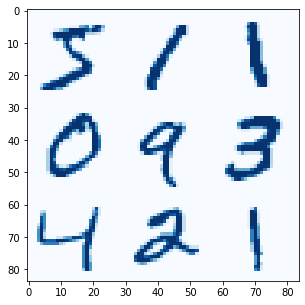

In [483]:
# Display MNIST digit grid
G = 3
plt.figure(figsize=[5, 5])
plt.imshow(np.hstack([np.vstack([X_train[i + G*j] for i in range(G)]) for j in range(G)]), cmap="Blues")
plt.show()

In [484]:
losses, acc = [], [] 
ttl = 128
epochs = 1000
for i in trange(epochs):
  # Create batch of random training input
  sample = np.random.randint(X_train.shape[0], size=ttl)
  inputs = torch.tensor(X_train[sample].reshape(-1, 784)).float()
  targets = torch.tensor(Y_train[sample]).long()
  
  # Forward
  net.zero_grad()
  output = net(inputs)
  loss = loss_fn(output, targets)
  guess = torch.argmax(output, dim=1)
  accuracy = (guess == targets).float().mean()
  loss = loss.mean()
  
  # Results
  losses.append(loss.item())
  acc.append(accuracy.item())
  
  # Backward
  loss.backward()
  optim.step()

100%|██████████| 1000/1000 [00:01<00:00, 514.91it/s]


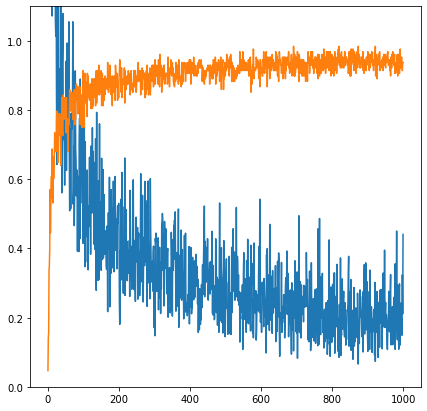

In [485]:
plt.figure(figsize=[7, 7])
plt.ylim([0, 1.1])
plt.plot(losses)
plt.plot(acc)
plt.show()

In [486]:
# Testing
inputs = torch.tensor(X_test).reshape(-1, 28 * 28).float()
targets = torch.tensor(Y_test).long()
output = net(inputs)
print("Accuracy: %.2f" % (torch.argmax(output, dim=1) == targets).float().mean().item())

Accuracy: 0.93


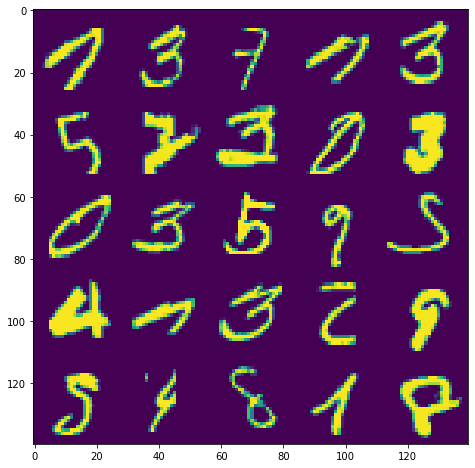

In [487]:
# Display Wrong Answers
bad = []
for i in range(1000):
  guess = torch.argmax(net(torch.tensor([X_train[999 + i].flatten()]).float()), dim=1)
  if guess != int(Y_train[999+i]):
    bad.append(X_train[999+i])

plt.figure(figsize=[8, 8])
sz = min(5, int(sqrt(len(bad))))
plt.imshow(np.hstack([np.vstack([bad[i + sz * j] for i in range(sz)]) for j in range(sz)]))
plt.show()

In [ ]:
# Notes:
# Learning rate 0.01 - 0.001 does not seem to change results
# Input layer count (assuming they contain 128 nodes) does not seem to change results
# nn.LogSoftMax w/ nn.NLLLoss seems to preform better than nn.SoftMax w/ nn.MSELoss